Currently using cpu...
Epoch 1 (40/1800): Loss=1.39082, Accuracy=0.30000
Epoch 1 (80/1800): Loss=1.49352, Accuracy=0.32500
Epoch 1 (120/1800): Loss=1.62912, Accuracy=0.28333
Epoch 1 (160/1800): Loss=1.67855, Accuracy=0.27500
Epoch 1 (200/1800): Loss=1.66972, Accuracy=0.26000
Epoch 1 (240/1800): Loss=1.62999, Accuracy=0.27083
Epoch 1 (280/1800): Loss=1.60830, Accuracy=0.27500
Epoch 1 (320/1800): Loss=1.57280, Accuracy=0.29375
Epoch 1 (360/1800): Loss=1.54470, Accuracy=0.30556
Epoch 1 (400/1800): Loss=1.51104, Accuracy=0.33000
Epoch 1 (440/1800): Loss=1.48932, Accuracy=0.33636
Epoch 1 (480/1800): Loss=1.47156, Accuracy=0.33958
Epoch 1 (520/1800): Loss=1.44274, Accuracy=0.36346
Epoch 1 (560/1800): Loss=1.42355, Accuracy=0.38036
Epoch 1 (600/1800): Loss=1.40726, Accuracy=0.39500
Epoch 1 (640/1800): Loss=1.38809, Accuracy=0.40938
Epoch 1 (680/1800): Loss=1.37300, Accuracy=0.41029
Epoch 1 (720/1800): Loss=1.34935, Accuracy=0.42361
Epoch 1 (760/1800): Loss=1.33351, Accuracy=0.42895
Epoch 1 (8

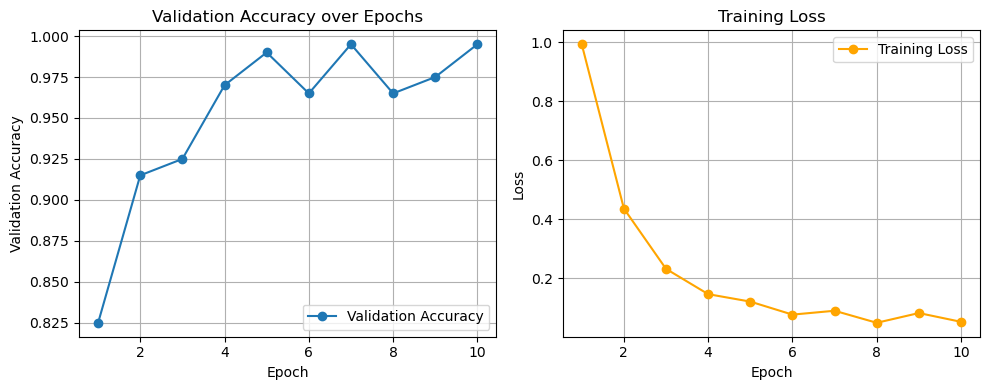

(5/60): Accuracy=0.60000
(10/60): Accuracy=0.80000
(15/60): Accuracy=0.86667
(20/60): Accuracy=0.85000
(25/60): Accuracy=0.88000
(30/60): Accuracy=0.90000
(35/60): Accuracy=0.91429
(40/60): Accuracy=0.92500
(45/60): Accuracy=0.91111
(50/60): Accuracy=0.92000
(55/60): Accuracy=0.92727
(60/60): Accuracy=0.93333
Overall Accuracy: 0.9333


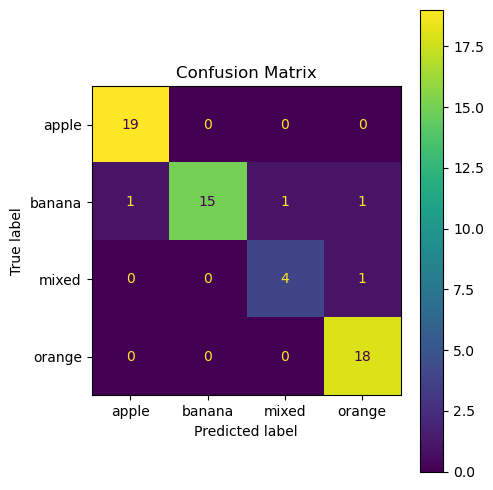

Test Precision: 0.9125, Recall: 0.9083, F1-score: 0.9077


In [1]:
import os, torch
import numpy as np
from torchvision import transforms
from PIL import Image, ImageOps

import torch.nn as nn

import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import random

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)


def dataset_labels(labels):
  label_list = list(set(labels))
  print(label_list)

def print_named_params(model):
  for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")


def prepare_data(target_dir, device):
  labels = []
  # Retrieves the names of all files in the target directory
  class_names = os.listdir(target_dir)
  # Removing gitignore file from dataset
  #class_names.remove(".gitignore")
  # TODO: Perform data cleansing here (e.g. renaming of misclassified dataset)
  # Creating a dict, using the index as the key and the filename as the value

  class_to_idx = [f"{target_dir}/{name}" for name in class_names]
  # Substring out the name of the fruit from the filename
  for class_name in class_names:
    labels.append(class_name.split("_")[0])
  # Binning each possible outcome into a dictionary
  # 0 = apple
  # 1 = banana
  # 2 = mixed
  # 3 = orange

  #binned_labels = { name: index for index, name in enumerate(sorted(set(labels))) }
  binned_labels = { "apple": 0, "banana": 1, "mixed": 2, "orange": 3 } #hardcoded to prevent errors


  # Converting categories into their assigned numerical bins
  binned_outputs = [binned_labels[name] for name in labels]
  return binned_labels, np.array(class_to_idx), torch.tensor(binned_outputs).to(device)


# Used for adding gaussian noise to the training data
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1, p=0.2):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if torch.rand(1).item() < self.p:
            noise = torch.randn_like(tensor) * self.std + self.mean
            return torch.clamp(tensor + noise, 0., 1.)
        return tensor

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std}, p={self.p})"
    

# Used for loading images and applying transformations for training data
def load_images(filepaths, device):
  # Define image transformation function
  transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    AddGaussianNoise(std=0.05, p=0.2) #added gaussian noise
    ])
  
  # Store tensor list for all images 
  tensor_list = []
 
  # Perform data conversion into tensors
  for image_path in filepaths:
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    tensor_list.append(image_tensor.unsqueeze(0).to(device))
    
  # Check if batch of tensors have been properly added to the list, else return empty tensor
  if tensor_list:
    result_tensor = torch.cat(tensor_list, dim=0)
    return result_tensor
  else:
    return torch.empty(0, 3, 160, 160, device=device)

# Used for resizing images with white padding for test data
class ResizeWithWhitePadding:
    def __init__(self, size):
        self.size = size  # (width, height) or just int for square

    def __call__(self, image):
        # Convert to RGB (in case of grayscale)
        image = image.convert("RGB")
        # Resize with aspect ratio preserved
        image.thumbnail((self.size, self.size), Image.Resampling.LANCZOS)
        # Add white padding
        padded_image = ImageOps.pad(image, (self.size, self.size), color=(255, 255, 255))
        return padded_image

# Used for test data (no augmentation)
def load_images2(filepaths, device):
  # Define image transformation function
  transform = transforms.Compose([
    ResizeWithWhitePadding(160),
    transforms.ToTensor()
    ])
  
  # Store tensor list for all images 
  tensor_list = []
 
  # Perform data conversion into tensors
  for image_path in filepaths:
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    tensor_list.append(image_tensor.unsqueeze(0).to(device))
    
  # Check if batch of tensors have been properly added to the list, else return empty tensor
  if tensor_list:
    result_tensor = torch.cat(tensor_list, dim=0)
    return result_tensor
  else:
    return torch.empty(0, 3, 160, 160, device=device)


class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # in_channels=3 for color images (RGB).
    # out_channels=16 means we have 16 filters, each filter of size 3x3x1.
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    
    # in_channels=16 because our out_channels=16 from previous layer.
    # out_channels=32 means we are using 32 filters, each filter of size 3x3x16,
    # in this layer.
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    
    # Max Pooling Layer: downsample by a factor of 2.
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Fully Connected Layer 1: input size = 40 * 40 * 32 (from feature maps), output size = 128.
    self.fc1 = nn.Linear(in_features= 40 * 40 * 32, out_features=128)
    
    # Fully Connected Layer 2: input size = 128, output size = 10 (for 10 output classes).
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    self.dropout = nn.Dropout(p=0.5)

    # Activation function
    self.relu = nn.ReLU()

  def forward(self, x):

    # Apply convolution + ReLU + pooling
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    # Flatten the feature maps 
    x = x.view(-1, 40 * 40 * 32)  #for 160x160

    x = self.dropout(x)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu(x)

    x = self.dropout(x)
    
    # Output layer (no activation since we apply softmax in the loss function)
    x = self.fc2(x)
    
    return x


def train(model, criterion, optimizer, filepaths, labels, val_filepaths, val_labels, device, epochs, patience=3):

  model.train()

  # our hyper-parameters for training
  n_epochs = epochs
  batch_size = 40

  best_val_acc = 0
  counter = 0
  best_model_state = None

  val_acc_history = []
  train_loss_history = []

  for epoch in range(n_epochs):
    # For tracking and printing our training-progress
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(filepaths) 

    permutation = torch.randperm(total_samples)
    for i in range(0, total_samples, batch_size):
      indices = permutation[i : i+batch_size]
      batch_inputs = load_images(filepaths[indices], device)
      batch_labels = labels[indices]
      
      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Compute loss
      loss = criterion(outputs, batch_labels)
      run_loss += loss.item()*batch_size

      # Backward pass and optimization step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Calculate some stats
      samples_trained += len(batch_labels)
      avg_loss = run_loss / samples_trained

      correct_preds += torch.sum(preds == batch_labels) # compare predictions with labels
      accuracy = correct_preds / float(samples_trained) # cast to float to get "accuracy" in decimal 

      print(f"Epoch {epoch+1} " +
            f"({samples_trained}/{total_samples}): " +
            f"Loss={avg_loss:.5f}, Accuracy={accuracy:.5f}")
      

    epoch_loss = run_loss / total_samples
    train_loss_history.append(epoch_loss)

    # Validation block
    model.eval()
    correct_val = 0
    total_val = len(val_filepaths)


    with torch.no_grad():
        for j in range(0, total_val, batch_size):
            val_inputs = load_images2(val_filepaths[j : j + batch_size], device)
            val_labels_batch = val_labels[j : j + batch_size]

            val_outputs = model(val_inputs)
            _, val_preds = torch.max(val_outputs, 1)

            correct_val += torch.sum(val_preds == val_labels_batch)

    val_accuracy = correct_val / float(total_val)
    val_acc_history.append(val_accuracy.item())
    print(f"Epoch {epoch+1} Validation Accuracy: {val_accuracy:.5f}\n")


    # Early stopping check
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s)")
        if counter >= patience:
            print("Early stopping triggered!")
            break

    model.train()

  # Restore best model weights
  if best_model_state is not None:
      model.load_state_dict(best_model_state)

  return val_acc_history, train_loss_history

      
def test(model, filepaths, labels, device):
  batch_size = 5
  samples_tested = 0
  correct_preds = 0
  total_samples = len(filepaths)

  all_preds = []
  all_targets = []

  filepaths = np.array(filepaths)
  labels = labels.clone()
  permutation = torch.randperm(total_samples)
  filepaths = filepaths[permutation.numpy()]
  labels = labels[permutation]

  model.eval()  # Set model to evaluation mode once

  with torch.no_grad():  # No gradients for the entire loop
  
    for i in range(0, total_samples, batch_size):
      batch_inputs = load_images2(filepaths[i : i + batch_size], device)
      batch_labels = labels[i : i + batch_size]

      # Forward pass: compute predicted outputs
      outputs = model(batch_inputs)

      # Get probability-distributions
      probs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(probs, dim=1)

      # Determine accuracy
      samples_tested += len(batch_labels)
      correct_preds += torch.sum(preds == batch_labels)
      accuracy = correct_preds / float(samples_tested)

      all_preds.extend(preds.cpu().numpy())
      all_targets.extend(batch_labels.cpu().numpy())

      print(f"({samples_tested}/{total_samples}): Accuracy={accuracy:.5f}")

  # Final accuracy
  accuracy = correct_preds / float(samples_tested)
  print(f"Overall Accuracy: {accuracy:.4f}")

  # Confusion matrix
  classnames = ["apple", "banana", "mixed", "orange"]
  cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classnames)

  fig, ax = plt.subplots(figsize=(5, 5))
  disp.plot(ax=ax, values_format="d")
  ax.set_title("Confusion Matrix")
  plt.tight_layout()
  plt.show()


  # Precision, Recall, F1
  from sklearn.metrics import precision_score, recall_score, f1_score

  precision = precision_score(all_targets, all_preds, average="macro")
  recall = recall_score(all_targets, all_preds, average="macro")
  f1 = f1_score(all_targets, all_preds, average="macro")

  print(f"Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")



# Set device type (check if you have a NVIDIA card)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using {device}...")
dir_train = "./train_augmented_500x4"
output_labels, filepaths, labels = prepare_data(dir_train, device)

# Instantiate the model, define the loss function and optimizer
model = SimpleCNN().to(device)

# Use 10% of the training data for validation
from sklearn.model_selection import train_test_split
filepaths_train, filepaths_val, labels_train, labels_val = train_test_split(
    filepaths, labels, test_size=0.1, stratify=labels.cpu(), random_state=42
)

# Train the model
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # add weight decay for regularization

val_acc_history, train_loss_history = train(model, criterion, optimizer, filepaths_train, labels_train, filepaths_val, labels_val, device, epochs=20, patience=3)

# Plotting validation accuracy and training loss---------------------------------------
epochs = range(1, len(val_acc_history) + 1)  # Epochs 1, 2, ..., N
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_acc_history, marker='o', label='Validation Accuracy')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, marker='o', color='orange', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
#-------------------------------------------------------------------------------------------


# Test the model
dir_test = "./test/"
_, filepaths, labels = prepare_data(dir_test, device)
test(model, filepaths, labels, device)